In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from lib.gen_utils import *
from lib.fog_gen import *
from lib.lime import *
from lib.gan_networks import *
from PIL import Image
from skimage import color
from Rain_Effect_Generator import RainEffectGenerator
from Snow_Effect_Generator import SnowEffectGenerator
from MiDaS_Depth_Estimation import *
from torchsummary import summary

/home/qninh/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(42)
random.seed(42)

In [3]:
def load_image(image_path):
    image = Image.open(image_path)
    image = np.array(image)
    return image

In [4]:
def show_image(images, titles=None):
    # show image horizontally
    fig, ax = plt.subplots(1, len(images), figsize=(5 * len(images), 5))

    for i, image in enumerate(images):
        if len(image.shape) == 3:
            fig.axes[i].imshow(image)
        else:
            fig.axes[i].imshow(image, cmap="gray")
        if titles:
            fig.axes[i].set_title(titles[i])
    plt.show()

## I. Analytical Methods

---


### Generate Illumination Map


In [5]:
lime = LIME(iterations=25, alpha=0.1)

In [6]:
IMAGE_PATH = "./data/images/7eb7131c-420e1747.jpg"  # day
# IMAGE_PATH = "./data/images/9db1088d-30de9c1b.jpg" # night

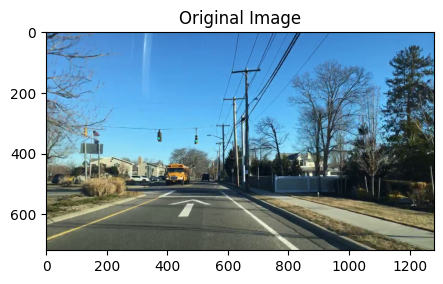

In [7]:
image = load_image(IMAGE_PATH)
show_image([image], ["Original Image"])

In [8]:
lime.load(image)
ill_map = lime.illumMap()

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:05<00:00,  4.18it/s]


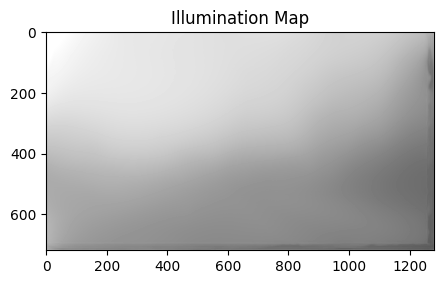

In [9]:
show_image([ill_map], ["Illumination Map"])

## Generate depth map using MiDAS and Foggy Image usign Beer-Lambert Law


In [10]:
if "midas" not in globals():
    midas, midas_transform = get_depth_estimation_model(
        model_name="DPT_Large", device="cuda"
    )

Using cache found in /home/qninh/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/qninh/.cache/torch/hub/intel-isl_MiDaS_master


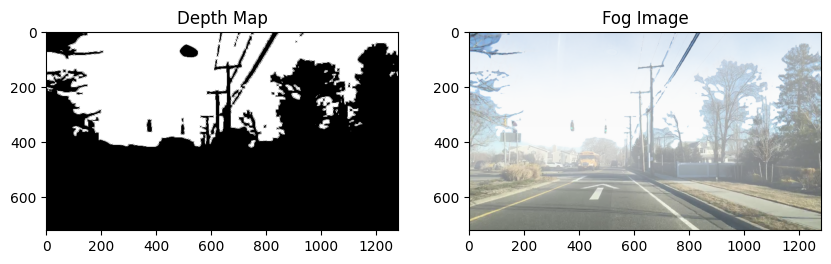

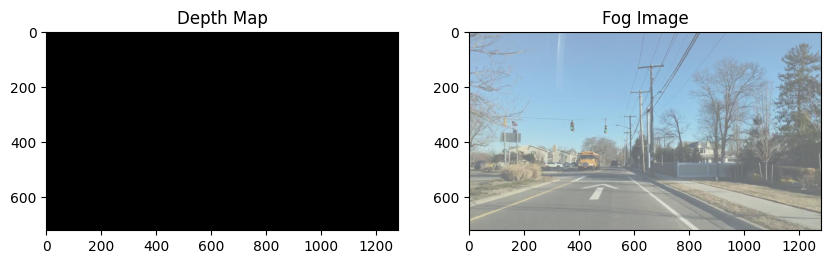

In [11]:
depth_map = get_depth_map(midas, midas_transform, IMAGE_PATH)

fog_image = generate_fog(image, depth_map)
show_image([depth_map / depth_map.max(), fog_image], ["Depth Map", "Fog Image"])

fake_depth_map = np.full_like(depth_map, 10)
fake_fog_image = generate_fog(image, fake_depth_map)
show_image(
    [fake_depth_map / fake_depth_map.max(), fake_fog_image], ["Depth Map", "Fog Image"]
)

### Generate a Gaussian noise 2D image


In [12]:
HEIGHT = 128
WIDTH = 320

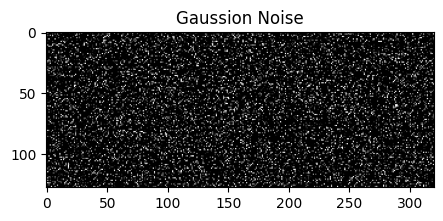

In [13]:
noise = generate_noisy_image(HEIGHT, WIDTH)
show_image([noise], ["Gaussion Noise"])

### Generate rain streak layer by applying 2D matrix convolution K

K is a matrix with the middle horizontal row being all ones and the rest being zeros.

$$
K = \begin{bmatrix}
0 & 0 & \ldots & 0 & 0 \\
0 & 0 & \ldots & 0 & 0 \\
\vdots & \vdots & \ddots & \vdots & \vdots \\
1 & 1 & \ldots & 1 & 1 \\
\vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 0 & \ldots & 0 & 0 \\
0 & 0 & \ldots & 0 & 0 \\
\end{bmatrix}


$$


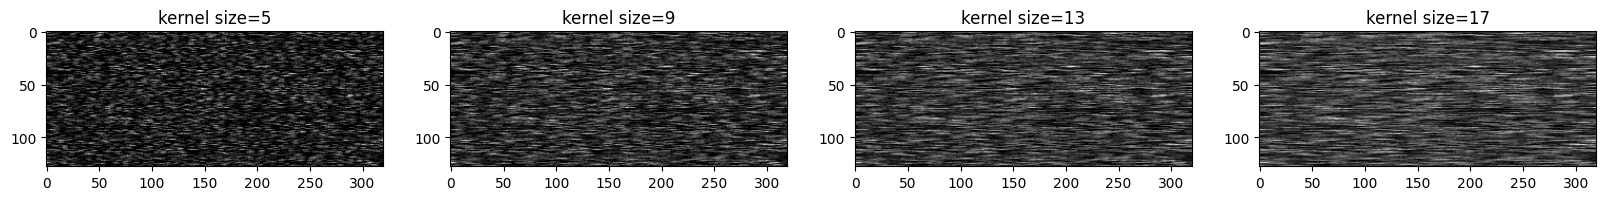

In [14]:
blur_kernels = [5, 9, 13, 17]

blur_noise = [apply_motion_blur_(noise, k) for k in blur_kernels]

show_image(blur_noise, titles=[f"kernel size={k}" for k in blur_kernels])

### Apply rotation matrix to rain streak layer to generate rain streak layer with different angle.


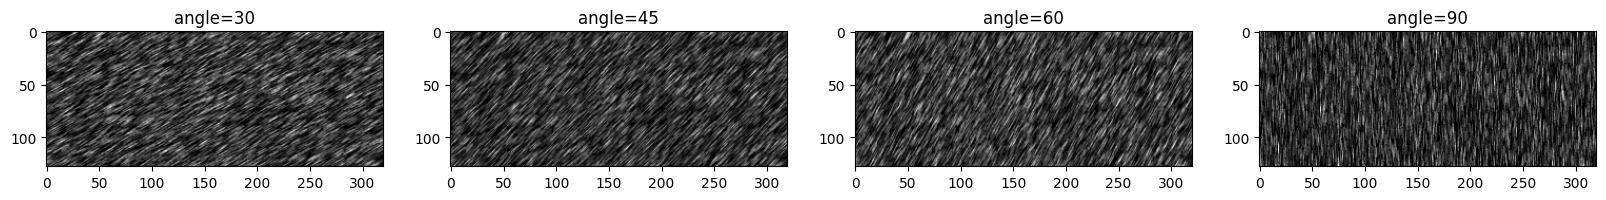

In [15]:
angples = [30, 45, 60, 90]

rotate_noise = [apply_motion_blur(noise, 9, angle=angle) for angle in angples]

show_image(rotate_noise, titles=[f"angle={angle}" for angle in angples])

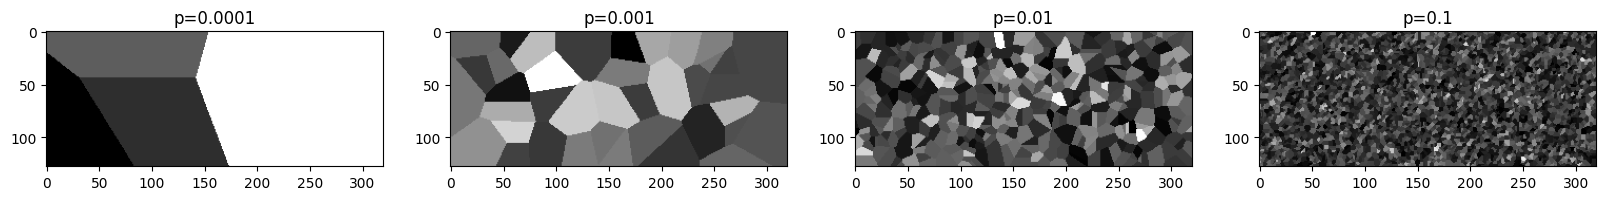

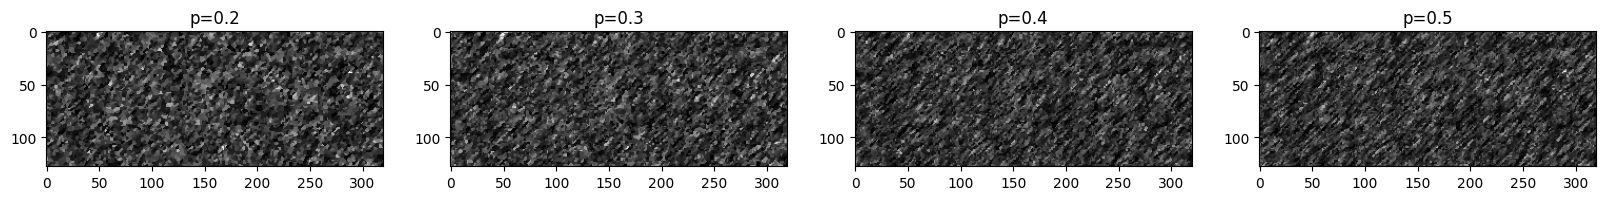

In [16]:
p = [0.0001, 0.001, 0.01, 0.1]
crystallize_noise = [crystallize(rotate_noise[1], amount) for amount in p]
show_image(crystallize_noise, titles=[f"p={amount}" for amount in p])

p = [0.2, 0.3, 0.4, 0.5]
crystallize_noise = [crystallize(rotate_noise[1], amount) for amount in p]
show_image(crystallize_noise, titles=[f"p={amount}" for amount in p])

### Rescale rain streak layer


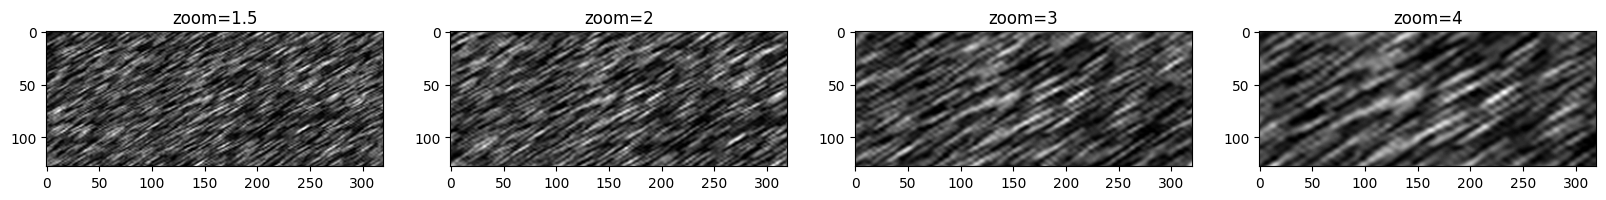

In [17]:
zoom_levels = [1.5, 2, 3, 4]

zoom_noise = [
    zoom_image_and_crop(image=rotate_noise[0], r=level) for level in zoom_levels
]

show_image(zoom_noise, titles=[f"zoom={level}" for level in zoom_levels])

## Generate rain layer by combining multiple layers

Let $R_1, R_2, \ldots, R_n$ be $n$ layers of rain with pixel values in the range $[0, 1]$.

The combined layer $R$:

$$
L = 1 - \prod_{i=1}^{n} (1 - R_i)
$$


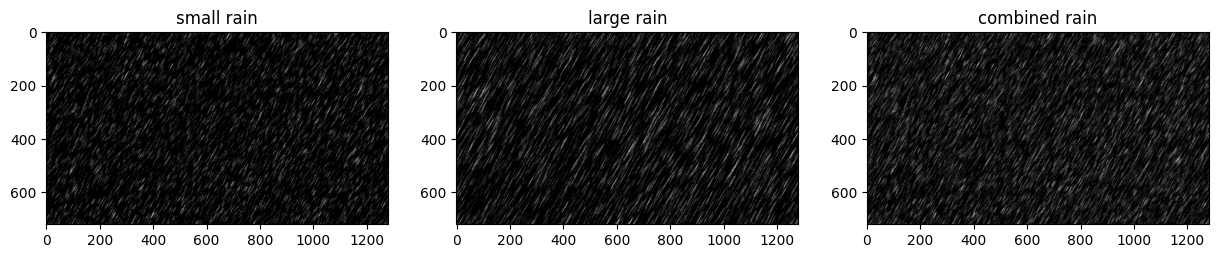

In [18]:
rain_generator = RainEffectGenerator(fog=True)
ANGLE = 60


large_rain_layer = rain_generator._rain_layer_gen.genRainLayer(
    h=720,
    w=1280,
    blur_kernel_size=23,
    blur_angle=ANGLE,
)  # large

small_rain_layer = rain_generator._rain_layer_gen.genRainLayer(
    h=720,
    w=1280,
    blur_kernel_size=11,
    blur_angle=ANGLE,
)  # small

rain_layer = layer_blend(small_rain_layer, large_rain_layer)

show_image(
    [small_rain_layer, large_rain_layer, rain_layer],
    ["small rain", "large rain", "combined rain"],
)

## Generate snow layer by combining multiple layers

Let $S_1, S_2, \ldots, S_n$ be $n$ layers of snow with pixel values in the range $[0, 1]$.

The combined layer $L$:

$$

L = 1 - \prod_{i=1}^{n} (1 - S_i)


$$


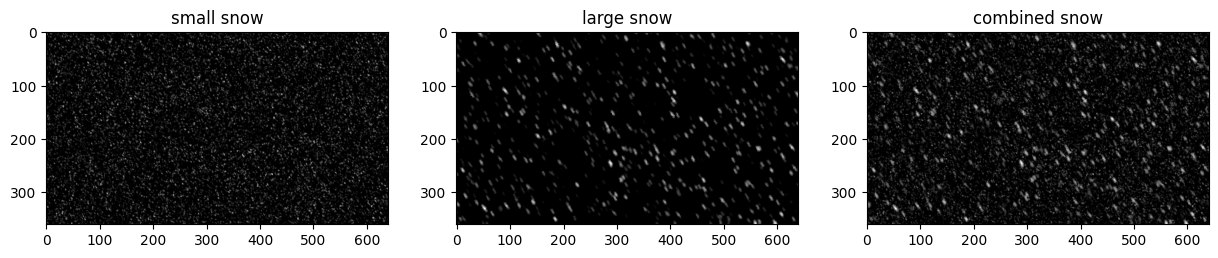

In [19]:
snow_generator = SnowEffectGenerator(fog=True)
ANGLE = 60


large_snow_layer = snow_generator._snow_layer_gen.genSnowMultiLayer(
    h=360,
    w=640,
    intensity="large",
    blur_angle=ANGLE,
)  # large

small_snow_layer = snow_generator._snow_layer_gen.genSnowMultiLayer(
    h=360,
    w=640,
    intensity="small",
    blur_angle=ANGLE,
)  # small

snow_layer = layer_blend(small_snow_layer, large_snow_layer)

show_image(
    [small_snow_layer, large_snow_layer, snow_layer],
    ["small snow", "large snow", "combined snow"],
)

In [20]:
rain_image = rain_generator.genEffect_(image, depth_map)
snow_image = snow_generator.genEffect_(image, depth_map)

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:06<00:00,  3.80it/s]


# HANDLE THIS THIS


In [ ]:
# rename all file in data/analyticity/snow_images
import os
import shutil

for i, filename in enumerate(os.listdir("./data/analyticity/snow_images")):
    os.rename(
        f"./data/analyticity/snow_images/{filename}",
        f"./data/analyticity/snow_images/{filename}.jpg",
    )

In [21]:
imgs = ["7ea536cf-9cb2ed5f.jpg", "7ee6d192-89e2408b.jpg", "8fd046f2-2db00000.jpg"]

for img in imgs:
    clear = load_image(f"./data/images/{img}")
    rain = load_image(f"./data/analyticity/rain_images/{img}")
    snow = load_image(f"./data/analyticity/snow_images/{img}")
    show_image([clear, rain, snow], ["Clear", "Rain (Analytical)", "Snow (Analytical)"])

FileNotFoundError: [Errno 2] No such file or directory: '/home/qninh/projects/Weather_Effect_Generator/data/analyticity/snow_images/7ea536cf-9cb2ed5f.jpg'

## 2. Generative Adversarial Network (GAN)


![](./resources/resnet_gan.png)

<center>GAN with Resnet</center>


In [ ]:
GAN = define_G(
    input_nc=3,
    output_nc=3,
    ngf=64,
    netG="resnet_9blocks",
    norm="instance",
    use_dropout=False,
    init_type="normal",
    init_gain=0.02,
    gpu_ids=[],
)

initialize network with normal


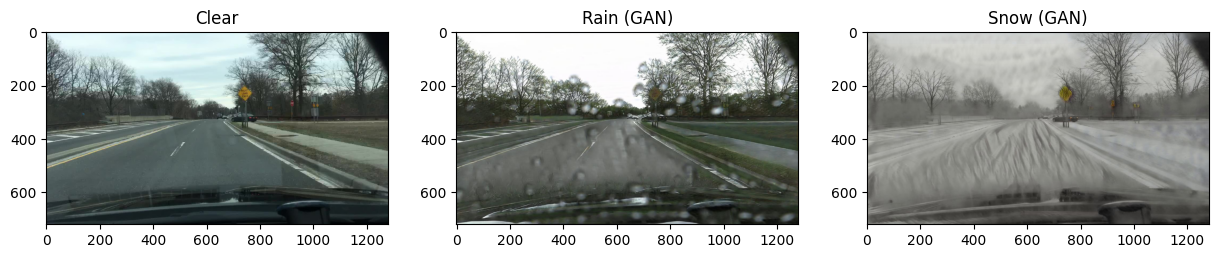

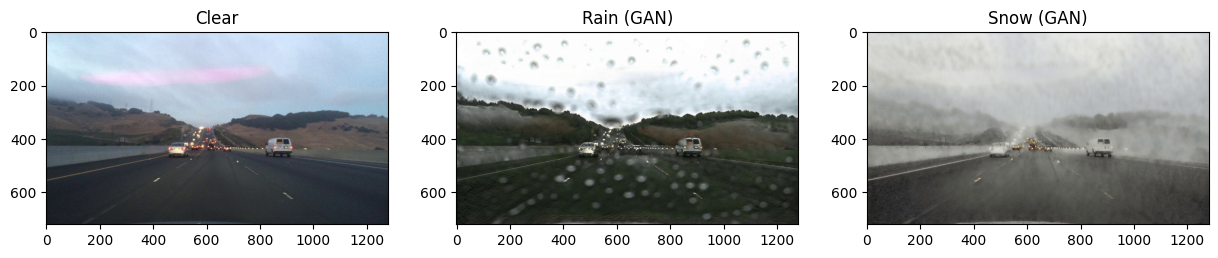

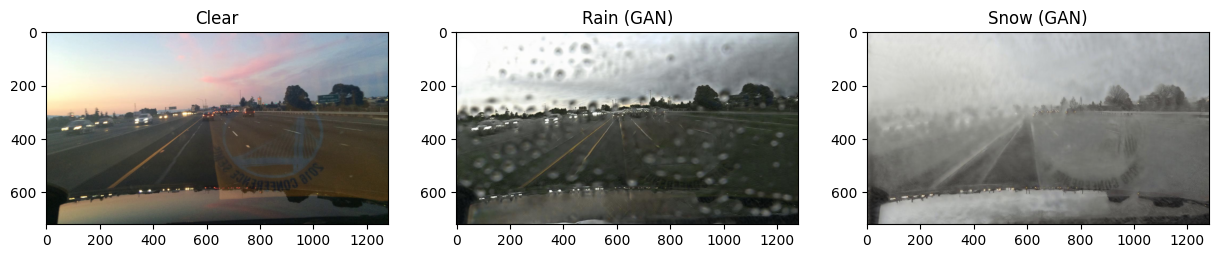

In [ ]:
imgs = ["7ea536cf-9cb2ed5f.jpg", "7ee6d192-89e2408b.jpg", "8fd046f2-2db00000.jpg"]

for img in imgs:
    clear = load_image(f"./data/images/{img}")
    rain = load_image(f"./data/gan/rain_images/{img}")
    snow = load_image(f"./data/gan/snow_images/{img}")
    show_image([clear, rain, snow], ["Clear", "Rain (GAN)", "Snow (GAN)"])

# =>> nhaanj xet


# Sau quas trinh explore code, trinh bay ua/nhuoc cua tung phuong phap

- Phan tich
  - anh loi (9db1088d-30de9c1b.jpg, 9a80bccb-2d450000.jpg)
  - nhieu tham so phai tuning
  - Bo test khong co rain streak (chu yeu suong mu hoac hat mua rat nho (gan nhu suong mu)), snow ball cung tuong tu
  - .....
- GAN:
  - Mua:
    - chi hoc duoc nhung hat mua tren kinh -> co the ket hop voi analytic method de sinh hat mua ben ngoai o to
  - Tuyet:
    - chi hoc duoc lop tuyet phu len duong nhua -> co the ket hop voi analytic method de sinh tuyet roi
    -

# trinh bay khi nao thi dung phuong phap nao


# De xuat

- Ghep analytic methods voi GAN -> vua co hat tuyet, vua co moi truong real


# Ly do denoise ko work

- Out of distribution:
  - Bo test:
    - chup tu rat nhieu goc do
    - anh rain co nhieu anh ma denoising model chua duoc train, nhin thay bao gio nhu:
      - anh co hat mua tren kinh o to -> khong xu ly duoc anh mua tren kinh o to
      - anh xe di qua vung nuoc -> nuoc bi ban len, xe di qua vung lut
